# Regresssion with outliers

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%%capture
%load_ext jupyter_probcomp.magics
%matplotlib inline

Load the read infer predict layer (ripl) and set venture's random seed to 1 to
ensure reproducibility.

In [3]:
%ripl --seed 7 --plugins plugins.py

Set seed of a new VentureScript RIPL to 7.00.
Loading plugin: plugins.py


## 1. Venture model component

In [4]:
%%venturescript
// MODEL
// Next, generate synthetic data.
define true_a = 2.5;
define true_b = 3;

define N = 20;

define max_xs = 13;
define regular_xs = mapv((_) -> {uniform_continuous(1, max_xs)}, arange(N));
define regular_ys = mapv((x) -> {true_a * x + true_b}, regular_xs);

define outliers_xs = [4, 6 , 8, 10];
define outliers_ys = [30, -12, -15, 37];

define data_xs = append(outliers_xs, regular_xs);
define data_ys = append(outliers_ys, regular_ys);

assume a = normal(0, 1) #continuous:0;
assume b = normal(0, 1) #continuous:1;
assume model_noise =  -log_logistic(log_odds_uniform() #continuous:2);
assume outlier_noise = 100;
assume outlier_probability = 0.01;

assume model = (x) -> { 
    if (bernoulli(outlier_probability) #discrete:x) {
        normal(0, outlier_noise)
    } else {
        normal(a * x + b, model_noise)
    }
};

## 3. Venture observation component

In [5]:
%%venturescript
// OBSERVATIONS
for_each(arange(size(data_xs)),
    (i) -> {
    observe model(${data_xs[i]}) = data_ys[i]
});

## 4. Venture infererence components

In [6]:
%%venturescript
// INFERENCE
define single_site_mh  = () -> {
    mh(default, one, 1)
};
define lbfgs_with_gibbs = () -> {
    gibbs(quote(discrete), one, 1);
    lbfgs_optimize(quote(continuous), all)
};
define loop_explicitly_over_random_choices = () -> {
    for_each(data_xs,
        (x) -> {
            gibbs(quote(discrete), x, 1)
    });
    mh(quote(continuous), 0, 1);
    mh(quote(continuous), 1, 1);
    mh(quote(continuous), 2, 1)
};
define hamiltonian_monte_carlo_with_gibbs = () -> {
    gibbs(quote(discrete), one, 1);
    hmc(quote(continuous), one, 0.1, 1, 1)
};
define SMC_single_site_single = () -> {
    for_each(arange(0, 5),
        (i) -> {
            observe model(${data_xs[i]}) = data_ys[i];
        });
    mh(default, one, 50);
    for_each(arange(5, size(data_xs)),
        (i) -> {
            observe model(${data_xs[i]}) = data_ys[i];
        });
};
define rejuvenation  = () -> {
    mh(default, one, 1)
};
define SMC_single_site_interleaved = () -> {
    for_each(arange(size(data_xs)),
        (i) -> {
            observe model(${data_xs[i]}) = data_ys[i];
            mh(default, one, 10);
        });
};
define shuffled_data_xs = shuffle(append(outliers_xs, regular_xs));
define shuffled_data_ys = shuffle(append(outliers_ys, regular_ys));
define SMC_single_site_interleaved2 = () -> {
    for_each(arange(size(shuffled_data_xs)),
        (i) -> {
            observe model(${shuffled_data_xs[i]}) = shuffled_data_ys[i];
            mh(default, one, 10);
        });
};
define rejuvenation  = () -> {
    mh(default, one, 1)
};

In [7]:
data_xs = %venturescript data_xs
data_ys = %venturescript data_ys
regular_xs = %venturescript regular_xs
regular_ys = %venturescript regular_ys
outliers_xs = %venturescript outliers_xs
outliers_ys = %venturescript outliers_ys

## 5. Execute inference programs and plot results

In [8]:
def plot_trace(trace_result, ax):
    all_x_values= trace_result['x']
    all_f_values = trace_result['f']
    ax.plot(all_x_values, all_f_values, color='blue')
    return ax

In [9]:
def get_trace(inf_prog, steps):
    %venturescript reset_to_prior;
    for _ in range(steps):
        %venturescript {inf_prog}();
    a = %venturescript sample(a)
    b = %venturescript sample(b)
    all_x_values= np.linspace(1, 13, 100)
    all_f_values = a * all_x_values + b
    return {'a' : a, 'b' : b, 'x' : all_x_values, 'f' : all_f_values}

In [10]:
def get_n_traces(inf_prog, n, steps):
    return [
        get_trace(inf_prog, steps)
        for _ in range(n)
    ]   

In [11]:
def plot_n_traces(inf_prog, trace_results):
    fig, ax = plt.subplots()
    for trace_result in trace_results[inf_prog]:
        plot_trace(trace_result, ax)
    ax.scatter(outliers_xs, outliers_ys, label='Outlier data', color='red')    
    ax.scatter(regular_xs, regular_ys, label='Regular data', color='green')
    ax.plot([], [], color='blue', label='5 samples')
    #ax.legend(
    #    loc='upper left',
    #    bbox_to_anchor=(1, 1),
    #    ncol=3,
    #    fontsize=12
    #)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_xlim([0, 15])
    ax.set_ylim([-20, 40])
    fig.tight_layout()
    fig.set_size_inches(2.5, 2)
    #fig.savefig('results/linear-regression-with-outliers/pdf-files/%s.pdf' % (inf_prog,), bbox_inches='tight',)
    #ax.set_title(procedures_to_name[inf_prog]);
    #fig.savefig('results/linear-regression-with-outliers//%s.png' % (inf_prog,), bbox_inches='tight',)

In [12]:
NUMBER_TRACES = 5

In [13]:
def run_inference(inf_prog):
    steps = int(all_inf_progs[inf_prog])
    return get_n_traces(inf_prog, NUMBER_TRACES, steps)

In [14]:
cd ..

/home/ulli/probcomp3/Venturecxx/benchmarks/inference-benchmarks


In [15]:
from benchmark_utils import read_json
from plotting_config import procedures_to_name, colors
from benchmark_utils import violates_pattern
from benchmark_utils import get_traces_at_time

In [16]:
cd linear-regression-with-outliers/

/home/ulli/probcomp3/Venturecxx/benchmarks/inference-benchmarks/linear-regression-with-outliers


In [17]:
def get_mean_number_iterations(inf_prog, time, all_results):
    pattern =  {'inf-prog-name': inf_prog, 'timing': time}
    iterations = []
    for result in all_results:
        if not violates_pattern(result, pattern):
            iterations.append(result['iterations'])
    return np.median(iterations)

In [18]:
lin_reg_progs = [
        'single_site_mh',
        'lbfgs_with_gibbs',
        'hamiltonian_monte_carlo_with_gibbs',
        'loop_explicitly_over_random_choices',
        #'SMC_HMC_rejuvenation',
        #'SMC_single_site_single',
        #'SMC_single_site_interleaved2',
        #'SMC_gibbs_lbfgs_single',
    ]

In [19]:
def get_result_data(path):
    result_files = glob.glob(path + 'results/*.json')
    return [read_json(filename) for filename in result_files]

In [20]:
all_inf_progs = {
    'hamiltonian_monte_carlo_with_gibbs': 400.5,
    'lbfgs_with_gibbs': 104.0,
    'loop_explicitly_over_random_choices': 46.0,
    'single_site_mh': 2607.0
}

In [21]:
trace_results = {
    inf_prog : run_inference(inf_prog)
    for inf_prog in lin_reg_progs
}

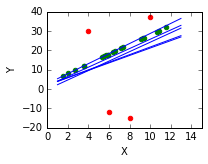

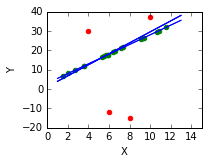

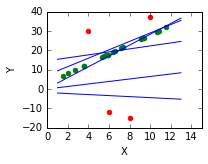

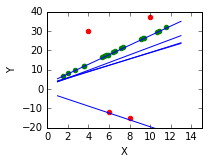

In [22]:
for inf_prog in lin_reg_progs:
    plot_n_traces(inf_prog, trace_results)

### Since we don't label observations, we can't really unincorporate them.

... thus we 're loading results for this one.

In [23]:
path = ''
data = get_result_data(path)

In [24]:
_, indeces = get_traces_at_time('SMC_single_site_interleaved2', 50, data)

In [25]:
def get_saved_trace(i):
    a = data[indeces[i]]['learned-parameters']['a']
    b = data[indeces[i]]['learned-parameters']['b']
    all_x_values= np.linspace(1, 13, 100)
    all_f_values = a * all_x_values + b
    return {'a' : a, 'b' : b, 'x' : all_x_values, 'f' : all_f_values}

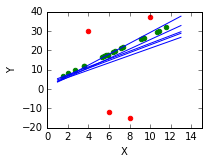

In [26]:
smc_results = [get_saved_trace(i) for i in range(6, 11)]
fig, ax = plt.subplots()
for trace_result in smc_results:
    plot_trace(trace_result, ax)
ax.scatter(outliers_xs, outliers_ys, label='Outlier data', color='red')    
ax.scatter(regular_xs, regular_ys, label='Regular data', color='green')
ax.plot([], [], color='blue', label='5 samples')
#ax.legend(
#    loc='upper left',
#    bbox_to_anchor=(1, 1),
#    ncol=3,
#    fontsize=12
#)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim([0, 15])
ax.set_ylim([-20, 40])
fig.tight_layout()
fig.set_size_inches(2.5, 2)
#fig.savefig('results/linear-regression-with-outliers/pdf-files/%s.pdf' % (inf_prog,), bbox_inches='tight',)
#ax.set_title(procedures_to_name[inf_prog]);
#fig.savefig('results/linear-regression-with-outliers//%s.png' % (inf_prog,), bbox_inches='tight',)